1. Load Data

In [8]:
import os

filename = 'select_preprocess_label_atop.csv'
folder = os.path.join("..", "0_dataset", "accounting")
models_folder = "models_accounting"
data_type = 'Accounting'

2. Define the Models

In [9]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import pickle
import numpy as np
import pandas as pd

core = -1 # your computer's maximum core numbers, for improving the training speed


models = {}
# traditional machine learning
# linear models
models['Logistic_Regression'] = LogisticRegression(max_iter=1500, n_jobs=core)
models['SGD'] = SGDClassifier(n_jobs=core)
models['Passive_Aggressive'] = PassiveAggressiveClassifier(n_jobs=core)
# non-linear models
models['Decision_Tree'] = DecisionTreeClassifier()
models['Extra_Tree'] = ExtraTreeClassifier()
models['Naive_Bayes'] = GaussianNB()
# models['SVM'] = SVC(kernel='rbf', gamma='auto')
models['KNN'] = KNeighborsClassifier(n_jobs=core)
# ensemble models
models['Random_Forest'] = RandomForestClassifier(n_jobs=core)
models['Ada_Boost'] = AdaBoostClassifier()
models['Bagging'] = BaggingClassifier(n_jobs=core)
models['Extra_Trees'] = ExtraTreesClassifier(n_jobs=core)
models['Gradient_Boosting'] = GradientBoostingClassifier()
models['XGBoost'] = XGBClassifier(n_jobs=core)

# deep learning

3. Training, testing, and evaluation

In [10]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing


evaluation = {}
for name in models:
    evaluation[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

df = pd.read_csv(os.path.join(folder, filename))

# build labeling map
label_original = sorted([int(i) for i in df['Label'].unique()])
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
le_origin_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
origin_le_mapping = dict(zip(le.transform(le.classes_), le.classes_))

X = df.drop(columns=['Label'])
X = X.values
y = df['Label'].values
y = y.reshape(-1)
y = le.transform(y)


# training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = SMOTE(n_jobs=-1, random_state=48).fit_resample(X_train, y_train)
print(sorted(pd.unique(y_test)))
print("X_train:{}, y_train:{}".format(len(X_train), len(y_train)))

for name, model in tqdm(models.items()):
    model_filename = os.path.join(models_folder, name)
    if os.path.exists(model_filename): # load the model from disk
        model = pickle.load(open(model_filename, 'rb'))
    else:
        model.fit(X_train, y_train)
        pickle.dump(model, open(model_filename, 'wb')) # save the model to disk
    y_hat = model.predict(X_test) # for f1 score
    
    # evaluation
    evaluation[name]['accuracy'].append(accuracy_score(y_test, y_hat,))
    evaluation[name]['precision'].append(precision_score(y_test, y_hat, average='weighted',zero_division=0))
    evaluation[name]['recall'].append(recall_score(y_test, y_hat, average='weighted', zero_division=0))
    evaluation[name]['f1_score'].append(f1_score(y_test, y_hat, average='weighted', zero_division=0))


c:\Users\user\anaconda3\envs\lab\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
X_train:679490, y_train:679490


  8%|▊         | 1/13 [15:02<3:00:26, 902.17s/it]c:\Users\user\anaconda3\envs\lab\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
 92%|█████████▏| 12/13 [55:33<09:47, 587.63s/it] c:\Users\user\anaconda3\envs\lab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:19:05] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 13/13 [58:20<00:00, 269.29s/it]


4. Show the model evalution result (F1 score)

In [11]:
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import math

def round_off(value, n):
    return math.floor(value * (10 ** n)) / float(10 ** n) 

models = [name.replace('_', '\n') for name in evaluation]
result = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}
for name in evaluation:
    for key, value in evaluation[name].items():
        result[key].append(round_off(mean(value), 3))

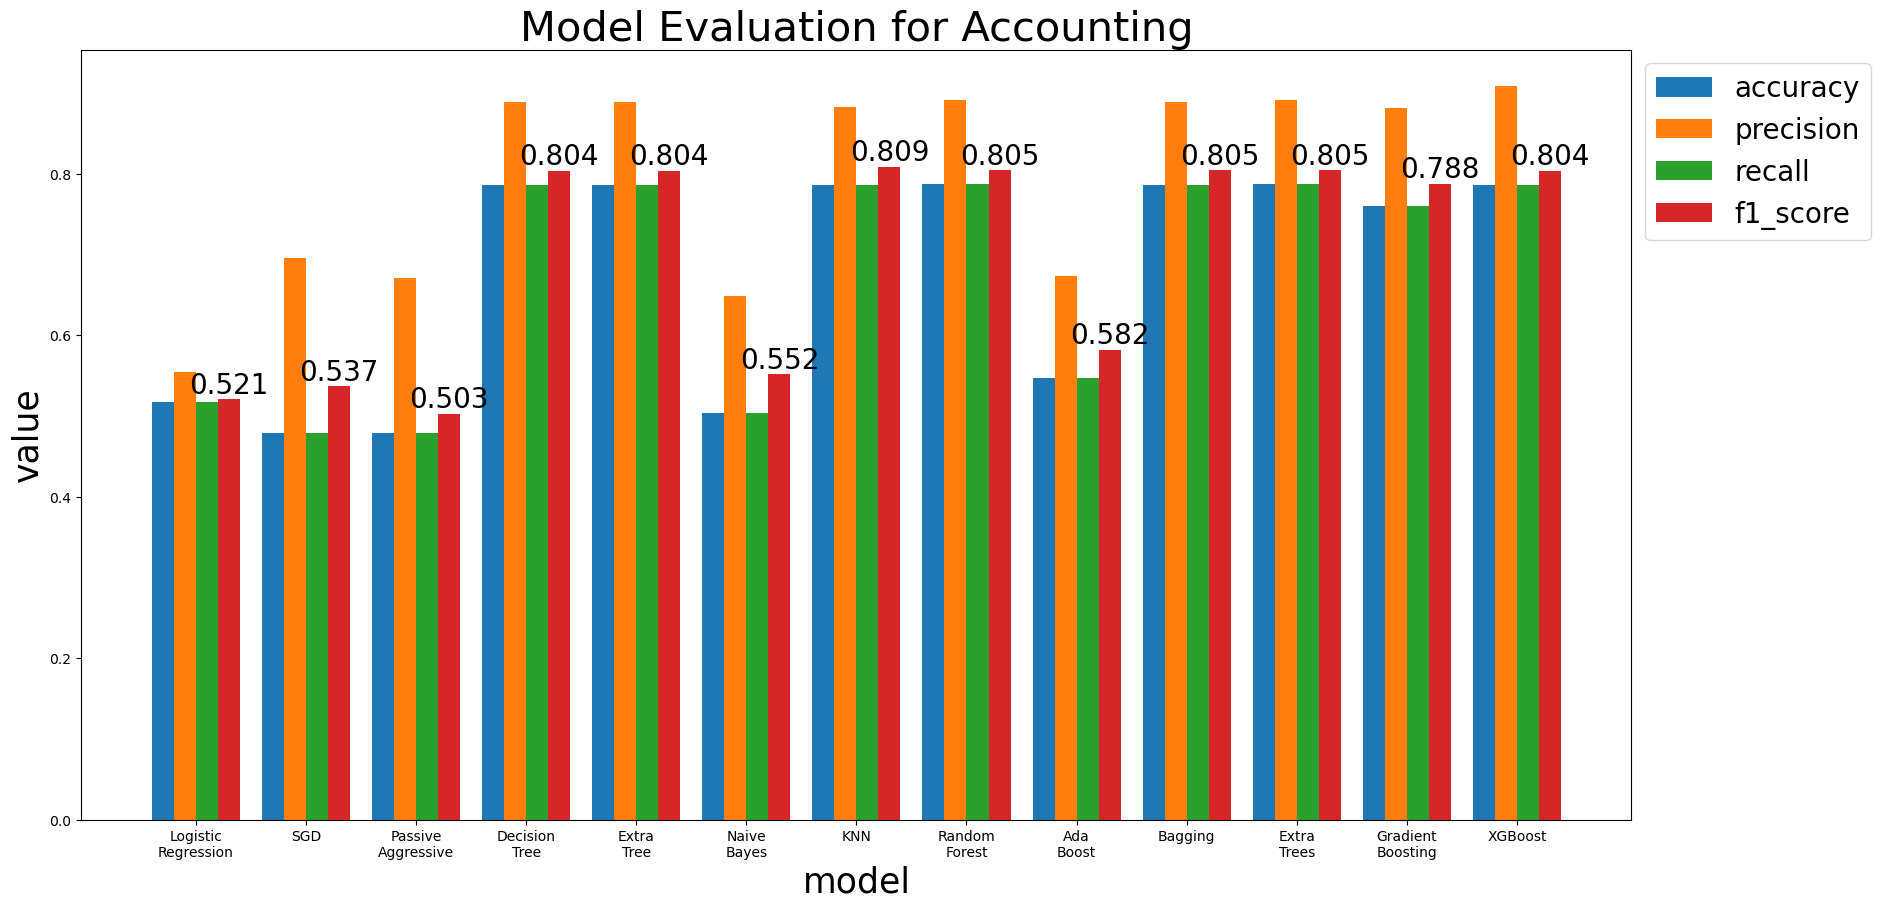

In [12]:
width = 0.2
x = np.arange(len(models))
plt.figure(figsize=(20, 10))
plt.bar(x, result['accuracy'], width, label='accuracy')
plt.bar(x+width, result['precision'], width, label='precision')
plt.bar(x+2*width, result['recall'], width, label='recall')
bar = plt.bar(x+3*width, result['f1_score'], width, label='f1_score')
plt.bar_label(bar, label_type='edge', fontsize=20)
plt.title('Model Evaluation for '+data_type, fontsize=30)
plt.xticks(x+1.5*width, models)
plt.xlabel('model', fontsize=25)
plt.ylabel('value', fontsize=25)
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 20,
})
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)
plt.show()

5. selected accounting model (confusion matrix, learning curve) 

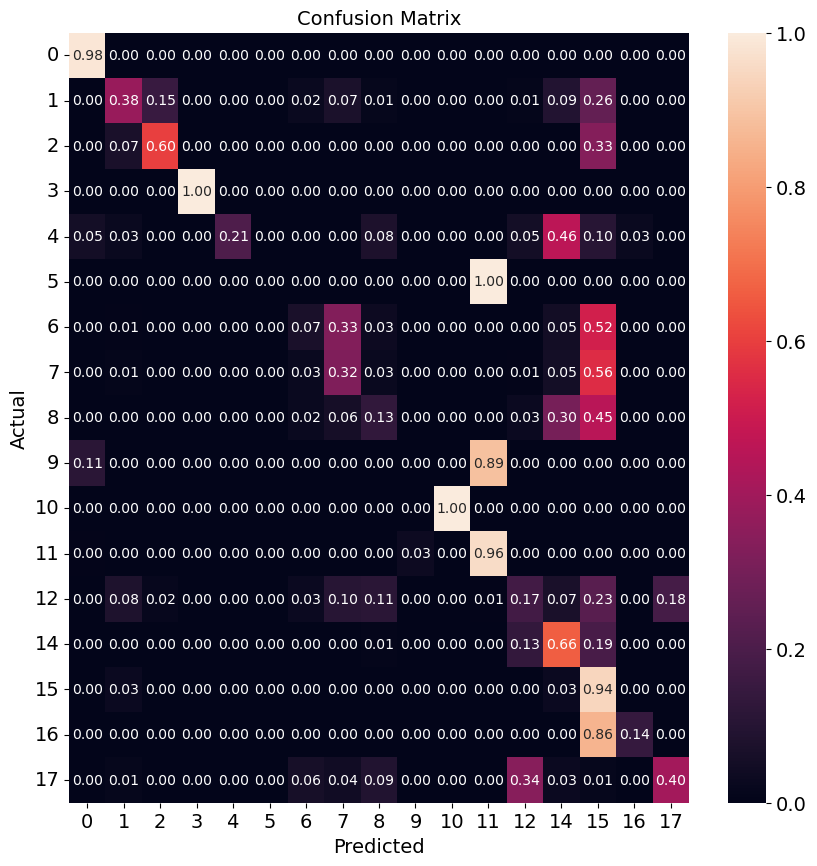

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

name = 'KNN'
model_filename = os.path.join(models_folder, name)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
target_names = label_original
model = pickle.load(open(model_filename, 'rb'))
y_hat = model.predict(X_test)

cm = confusion_matrix(y_test, y_hat)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show(block=False)

# tree.export_graphviz(model)